In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import random_split
import random
import os
#import Image
from PIL import Image

# Check if MPS (Apple's Metal Performance Shaders) or CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to your dataset
data_dir = "./frames/dataset/"


# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a slightly larger size before cropping
    transforms.RandomCrop(224),     # Randomly crop to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the images
    transforms.RandomRotation(10),      # Randomly rotate the images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Lambda(lambda img: overlay_human_silhouette(img)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
# List full path of silhouette images
silhouette_image_paths = [os.path.join("./silhoutte/", path) for path in os.listdir("./silhoutte/") if path.endswith('.png')]

# Load silhouette images
silhouette_images = [Image.open(path).convert("RGBA") for path in silhouette_image_paths]

# Define a function to overlay human silhouette
def overlay_human_silhouette(image):
    silhouette = random.choice(silhouette_images)
    silhouette = silhouette.resize((random.randint(50, 100), random.randint(100, 200)))

    x, y = random.randint(0, image.width - silhouette.width), random.randint(0, image.height - silhouette.height)
    image.paste(silhouette, (x, y), silhouette)
    return image









In [2]:
# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Data loaders
batch_size_m = 50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_m, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_m, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_m, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


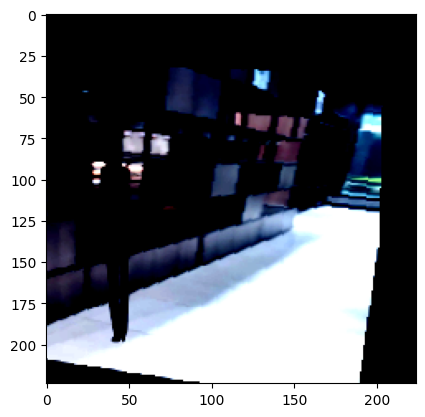

Label: 4


In [3]:
import matplotlib.pyplot as plt

# Fetch one batch of images from the train_loader
images, labels = next(iter(train_loader))

# Display the first image in this batch
image = images[0]

# Convert the image from PyTorch tensor to a NumPy array
# and change the order of dimensions for plotting
image = image.numpy().transpose(1, 2, 0)

# Plot the image
plt.imshow(image)
plt.show()

# Optionally, print the label of the image
print("Label:", labels[0].item())


Counter({13: 3199, 12: 3099, 6: 3054, 21: 2873, 1: 2833, 4: 2736, 18: 2658, 20: 2600, 10: 2439, 5: 2438, 14: 2420, 0: 2327, 2: 2318, 7: 2280, 23: 2259, 8: 2219, 22: 2118, 16: 1954, 17: 1839, 9: 1699, 3: 1559, 19: 1360, 25: 1317, 26: 1317, 24: 1260, 11: 839, 15: 400})
57414


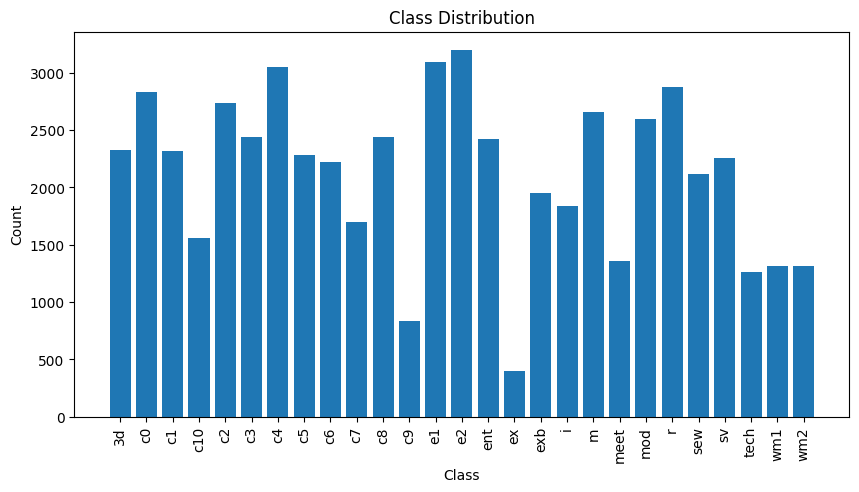

In [3]:

# view class distribution
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# get count of each class
label_counts = Counter(dataset.targets)
total_count = len(dataset.targets)
print(label_counts)
print(total_count)

#PLOT
#find the class names
class_names = dataset.classes
labels = class_names
counts = label_counts.values()
plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
#make it a bit mor wide
plt.xticks(rotation=90)
plt.show()


In [4]:
dataset.classes

['3d',
 'c0',
 'c1',
 'c10',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'e1',
 'e2',
 'ent',
 'ex',
 'exb',
 'i',
 'm',
 'meet',
 'mod',
 'r',
 'sew',
 'sv',
 'tech',
 'wm1',
 'wm2']

In [6]:
import torch.nn.functional as F


import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomLabZoneModel(nn.Module):
    def __init__(self, num_classes=37):
        super(CustomLabZoneModel, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)  # Adjust the input features size accordingly
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create an instance of the model
model = CustomLabZoneModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
# Load a pre-trained ResNet50 model
model_resnet50 = models.resnet50(pretrained=True)

# Unfreeze some of the layers for fine-tuning
for name, child in model_resnet50.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# Modify the final layer for  len(dataset.classes) classes
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs,  len(dataset.classes))

model_resnet50 = model_resnet50.to(device)

# Define loss function and optimizer for ResNet50
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [5]:
# Load a pre-trained ResNet101 model
model_resnet101 = models.resnet101(pretrained=True)

# Modify the final layer for  len(dataset.classes) classes
num_ftrs = model_resnet101.fc.in_features
model_resnet101.fc = nn.Linear(num_ftrs,  len(dataset.classes))

model_resnet101 = model_resnet101.to(device)

# Define loss function and optimizer for ResNet101
optimizer = optim.Adam(model_resnet101.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Load a pre-trained model (ResNet18 in this case) and modify it
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))  # Adjusting for the number of classes
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:

# Helper function to calculate metrics
def calculate_metrics(loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support



def train_model(num_epochs=10, run_name=""):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate training metrics
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train_loader)
        # Calculate validation metrics
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_loader)

        print(f"Epoch {epoch+1} / {num_epochs}.." \
              f"Train loss: {running_loss/len(train_loader):.3f}.." \
              f"Train accuracy: {train_accuracy:.3f}.." \
              f"Train precision: {train_precision:.3f}.." \
              f"Train recall: {train_recall:.3f}.." \
              f"Train f1: {train_f1:.3f}.." \
              f"Validation accuracy: {val_accuracy:.3f}.." \
              f"Validation precision: {val_precision:.3f}.." \
                f"Validation recall: {val_recall:.3f}.." \
                f"Validation f1: {val_f1:.3f}")
        
        # Logging metrics to W&B
        wandb.log({
            "Epoch": epoch+1,
            "Loss": running_loss/len(train_loader),
            "Train Accuracy": train_accuracy,
            "Train Precision": train_precision,
            "Train Recall": train_recall,
            "Train F1": train_f1,
            "Validation Accuracy": val_accuracy,
            "Validation Precision": val_precision,
            "Validation Recall": val_recall,
            "Validation F1": val_f1
        })

        #check if directory exists
        if not os.path.exists(f"./models/{run_name}/"):
            os.makedirs(f"./models/{run_name}/")
        # Save model checkpoints to W&B
        
        torch.save(model.state_dict(), f"./models/{run_name}/"+f"epoch_{epoch+1}.pth")
        # wandb.save(f"./models/{run_name}_epoch_{epoch+1}.pth")

    print("Finished Training")






In [8]:
name = "custom_simple"

# Initialize a new W&B run
wandb.init(project="PicfPos", name=name)

# Watch the model to log all gradients and parameters
wandb.watch(model)
# Train the model
train_model(num_epochs=10, run_name=name)

## Remember to close the W&B run when done
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amanex (amnx). Use `wandb login --relogin` to force relogin


Epoch 1 / 10..Train loss: 2.871..Train accuracy: 0.276..Train precision: 0.288..Train recall: 0.276..Train f1: 0.255..Validation accuracy: 0.264..Validation precision: 0.278..Validation recall: 0.264..Validation f1: 0.243
Epoch 2 / 10..Train loss: 2.196..Train accuracy: 0.435..Train precision: 0.468..Train recall: 0.435..Train f1: 0.429..Validation accuracy: 0.424..Validation precision: 0.455..Validation recall: 0.424..Validation f1: 0.419
Epoch 3 / 10..Train loss: 1.748..Train accuracy: 0.541..Train precision: 0.545..Train recall: 0.541..Train f1: 0.538..Validation accuracy: 0.527..Validation precision: 0.530..Validation recall: 0.527..Validation f1: 0.524
Epoch 4 / 10..Train loss: 1.469..Train accuracy: 0.592..Train precision: 0.607..Train recall: 0.592..Train f1: 0.590..Validation accuracy: 0.580..Validation precision: 0.592..Validation recall: 0.580..Validation f1: 0.575
Epoch 5 / 10..Train loss: 1.270..Train accuracy: 0.654..Train precision: 0.667..Train recall: 0.654..Train f1: 0

Epoch,▁▂▃▃▄▅▆▆▇█
Loss,█▆▄▃▃▂▂▁▁▁
Train Accuracy,▁▃▅▅▆▇▇▇██
Train F1,▁▃▅▆▆▇▇███
Train Precision,▁▄▅▆▆▇▇▇██
Train Recall,▁▃▅▅▆▇▇▇██
Validation Accuracy,▁▃▅▆▆▇▇▇██
Validation F1,▁▃▅▆▆▇▇▇██
Validation Precision,▁▄▅▆▆▇▇▇██
Validation Recall,▁▃▅▆▆▇▇▇██
Epoch,10


In [9]:
name = "FC_Res101_simple"
model = model_resnet101
# Initialize a new W&B run
wandb.init(project="PicfPos", name=name)

# Watch the model to log all gradients and parameters
wandb.watch(model)
# Train the model
train_model(num_epochs=10, run_name=name)

## Remember to close the W&B run when done
wandb.finish()



Epoch,▁
Loss,▁
Train Accuracy,▁
Train F1,▁
Train Precision,▁
Train Recall,▁
Validation Accuracy,▁
Validation F1,▁
Validation Precision,▁
Validation Recall,▁
Epoch,1


Epoch 1 / 10..Train loss: 1.042..Train accuracy: 0.697..Train precision: 0.740..Train recall: 0.697..Train f1: 0.699..Validation accuracy: 0.680..Validation precision: 0.731..Validation recall: 0.680..Validation f1: 0.683
Epoch 2 / 10..Train loss: 0.642..Train accuracy: 0.836..Train precision: 0.843..Train recall: 0.836..Train f1: 0.835..Validation accuracy: 0.823..Validation precision: 0.831..Validation recall: 0.823..Validation f1: 0.822
Epoch 3 / 10..Train loss: 0.444..Train accuracy: 0.879..Train precision: 0.885..Train recall: 0.879..Train f1: 0.879..Validation accuracy: 0.865..Validation precision: 0.872..Validation recall: 0.865..Validation f1: 0.864
Epoch 4 / 10..Train loss: 0.343..Train accuracy: 0.880..Train precision: 0.891..Train recall: 0.880..Train f1: 0.880..Validation accuracy: 0.864..Validation precision: 0.875..Validation recall: 0.864..Validation f1: 0.864
Epoch 5 / 10..Train loss: 0.280..Train accuracy: 0.903..Train precision: 0.907..Train recall: 0.903..Train f1: 0

Epoch,▁▂▃▃▄▅▆▆▇█
Loss,█▅▃▃▂▂▂▁▁▁
Train Accuracy,▁▅▆▆▇▇██▇█
Train F1,▁▅▆▆▇▇██▇█
Train Precision,▁▄▆▆▆▇██▇█
Train Recall,▁▅▆▆▇▇██▇█
Validation Accuracy,▁▅▆▆▇▇██▇█
Validation F1,▁▅▆▆▇▇██▇█
Validation Precision,▁▄▆▆▆▇▇█▇█
Validation Recall,▁▅▆▆▇▇██▇█
Epoch,10


In [ ]:
# Optionally, you can save the trained model
torch.save(model.state_dict(), 'model.pth')

In [ ]:
from PIL import Image
import torchvision.transforms as transforms



# Function to preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function for inference
def predict_image(model, image_path, class_names):
    image = preprocess_image(image_path)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted[0].item()]

    return predicted_class

# Example usage
# image_path = '/Users/amnx/Code/PICfPOS/frame_0304 copy.jpeg'
# model = torch.load('model.pth')
  # Make sure this is your trained model
class_names = dataset.classes  # The class names from your dataset

# predicted_class = predict_image(model, image_path, class_names)
# print(f"Predicted class: {predicted_class}")


In [ ]:
#load model saved as torch.save(model.state_dict(), 'model.pth')

model.load_state_dict(torch.load('./model_aaa_4.pth'))


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([26, 512]) from checkpoint, the shape in current model is torch.Size([24, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([26]) from checkpoint, the shape in current model is torch.Size([24]).

In [ ]:
#start reading a video IMG_0387.MOV
import cv2
import os

# Path to your video file
video_path = r"C:\Users\aman.sa\Documents\code\PicfPos\Image classifier\input folder\IMG_0387.MOV"

# Directory to save the frames
if not os.path.exists('demo'):
    os.makedirs('demo')
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Function to preprocess image
def preprocess_image(frame):
    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Define your preprocessing steps here
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0)

# Rest of your code remains the same

# Start capturing the feed
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output_resnet50_custom_e10.mp4', fourcc, 60.0, (int(cap.get(3)), int(cap.get(4))))
frame_count = 0
while True:
    ret, frame = cap.read()
    if ret == False:
        break
    #preprocess the frame and predict the class
    image = preprocess_image(frame)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted[0].item()]
    #save the video with annotation of the class predicted
    cv2.putText(frame, predicted_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    out.write(frame)
    
    

cap.release()
out.release()
cv2.destroyAllWindows()



In [ ]:
cap = cv2.VideoCapture(video_path)
frame_count = 0
while True:
    ret, frame = cap.read()
    if ret == False:
        break
    frame_count += 1
cap.release()
print(f"Total frames: {frame_count}")

Total frames: 4936
